# Data Preparation

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import random
import time
import matplotlib.pyplot as plt

In [2]:
#Read each line in train/test file and split word and its part-of-speech by '/' seperator
def read(file):
    with open(file, 'r', encoding='utf8') as f:
        file = f.read().splitlines()
    data = [[] for _ in range(len(file))]
    for idx, i in enumerate(file):
        a = i.split()
        for j in a:
            tmp = (j.rsplit('/',1))
            data[idx].append((tmp[0], tmp[1]))
    return data

In [3]:
#Load training corpus and testing file to memory
train_set = read('../corpus/train.txt')
test_set = read('../corpus/test.txt')

In [4]:
#Create list of train and test tagged words
train_tagged_words = [tup for sent in train_set for tup in sent]
test_tagged_words = [tup[0] for sent in test_set for tup in sent]

In [5]:
#Let's check how many unique tags are present in training data
tags = {tag for word,tag in train_tagged_words}
print(len(tags))
print(tags)

16
{'CCONJ', 'PROPN', 'ADV', 'NOUN', 'AUX', 'X', 'PUNCT', 'DET', 'PRON', 'PART', 'NUM', 'ADP', 'SYM', 'VERB', 'SCONJ', 'ADJ'}


In [6]:
unique_tags = len(tags)

In [7]:
#Let's check how many words are present in vocabulary
vocab = {word for word,tag in train_tagged_words}
print(len(vocab))

1004


### Visualization for number of tags in train set

In [8]:
# count = {i:0 for i in tags}

In [9]:
# for i in train_tagged_words:
#     pos = i[1]
#     count[pos] += 1

In [10]:
# plt.rcParams["figure.figsize"] = (15,8)
# plt.bar(range(len(count)), list(count.values()), align='center')
# plt.xticks(range(len(count)), list(count.keys()))
# plt.xticks(rotation=45)
# plt.show()

### POS Tagging using Hidden Markov Model (HMM)

We'll use the HMM algorithm to tag the words. Given a sequence of words to be tagged, the task is to assign the most probable tag to the word. 
In other words, to every **word w**, assign **the tag t** that maximises the likelihood **$P(t|w)$**. 

Since $$P(t|w) = {{P(w|t)*P(t)} \over {P(w)}}$$ 
After ignoring $P(w)$, we have to compute $P(w|t)$ and $P(t)$.

Now:
* **$P(w|t)$: is the emission probability** of a given word for a given tag. This can be computed based on the fraction of given word for given tag to the total count of that tag, ie: $$P(w|t) = count(w, t) \over count(t)$$. However, if the training data is small and not cover enough cases, the emission probability can lead to zero. Therefore we need to use a method called **Laplace smoothing** which adds a value to the numerator to prevent zero probability. The equation above can be written:
$$P(w|t) = count(w, t) + 1 \over count(t)+ N$$  which N is the number of unique tags in training data



* **$P(t)$: is the probability of tag (also transition probability)**, and in a tagging task, we assume that a tag will depend only on the previous tag (Markov order 1 assumption). In other words, the probability of say a tag being NOUN will depend only on the previous tag $t(n-1)$. So for e.g. if $t(n-1)$ is a ADJ, then $t(n)$ is likely to be an NOUN since adjectives often precede a noun (blue coat, tall building etc.).



# Build the Viterbi POS tagger

#### Function to compute emission probabilties for a given word

In [11]:
#Compute emission probability for a given word for a given tag
def word_given_tag(word, tag, train_bag=train_tagged_words):
    taglist = [pair for pair in train_bag if pair[1] == tag]
    #Use laplace smoothing to prevent zero probability
    tag_count = len(taglist) + len(vocab)
    w_in_tag = [pair[0] for pair in taglist if pair[0] == word]
    word_count_given_tag = len(w_in_tag) + 1
    return (word_count_given_tag, tag_count)

#### Function to compute transition probabilties for a given tag and previous tag

In [12]:
#Compute transition probabilities of a previous and next tag
def t2_given_t1(t2,t1,train_bag=train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    t1_tags = [tag for tag in tags if tag==t1]  
    count_of_t1 = len(t1_tags) + unique_tags 
    t2_given_t1 = [tags[index+1] for index in range(len(tags)-1) if tags[index] == t1 and tags[index+1] == t2] 
    count_t2_given_t1 = len(t2_given_t1) + 1  
    return(count_t2_given_t1,count_of_t1)

In [13]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)
tags_matrix = np.zeros((len(tags), len(tags)), dtype='float32')
for i, t1 in enumerate(list(tags)):
    for j, t2 in enumerate(list(tags)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [14]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(tags), index=list(tags))

In [15]:
tags_df

,CCONJ,PROPN,ADV,NOUN,AUX,X,PUNCT,DET,PRON,PART,NUM,ADP,SYM,VERB,SCONJ,ADJ
CCONJ,0.011494,0.137931,0.080460,0.149425,0.057471,0.011494,0.057471,0.091954,0.068966,0.011494,0.022989,0.045977,0.011494,0.114943,0.022989,0.103448
PROPN,0.066667,0.193939,0.006061,0.127273,0.018182,0.006061,0.260606,0.024242,0.006061,0.054545,0.096970,0.066667,0.018182,0.024242,0.006061,0.024242
ADV,0.017442,0.011628,0.063953,0.034884,0.029070,0.005814,0.238372,0.040698,0.040698,0.005814,0.005814,0.063953,0.005814,0.273256,0.040698,0.122093
NOUN,0.050373,0.018657,0.031716,0.166045,0.061567,0.001866,0.276119,0.018657,0.031716,0.022388,0.003731,0.194030,0.001866,0.104478,0.011194,0.005597
AUX,0.015873,0.015873,0.103175,0.031746,0.039683,0.007937,0.047619,0.111111,0.071429,0.063492,0.023810,0.031746,0.007937,0.285714,0.007937,0.134921
X,0.050000,0.050000,0.050000,0.100000,0.050000,0.050000,0.200000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000
PUNCT,0.072193,0.101604,0.090909,0.050802,0.032086,0.010695,0.101604,0.106952,0.152406,0.002674,0.010695,0.090909,0.002674,0.088235,0.053476,0.029412
DET,0.003521,0.080986,0.070423,0.482394,0.021127,0.003521,0.003521,0.017606,0.028169,0.003521,0.007042,0.007042,0.003521,0.042254,0.003521,0.221831
PRON,0.005376,0.005376,0.086022,0.086022,0.215054,0.005376,0.075269,0.021505,0.048387,0.005376,0.005376,0.053763,0.005376,0.338710,0.010753,0.032258
PART,0.023810,0.047619,0.071429,0.404762,0.047619,0.023810,0.023810,0.023810,0.023810,0.023810,0.047619,0.023810,0.023810,0.119048,0.023810,0.047619


In [16]:
emission_matrix = np.zeros((len(tags), len(vocab)), dtype='float32')
for i, t1 in enumerate(list(tags)):
    for j, t2 in enumerate(list(tags)): 
        emission_matrix[i, j] = word_given_tag(t2, t1)[0]/word_given_tag(t2, t1)[1]

In [17]:
emission_matrix = pd.DataFrame(emission_matrix, columns = list(vocab), index=list(tags))

In [18]:
emission_matrix

,satisfy,must,career,contexts,national,focused,adored,South,finally,third,...,do,IPL,visit,Test,this,applies,Squid,determined,statement,staffing
CCONJ,0.000930,0.000930,0.000930,0.000930,0.000930,0.000930,0.000930,0.000930,0.000930,0.000930,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PROPN,0.000867,0.000867,0.000867,0.000867,0.000867,0.001735,0.000867,0.000867,0.000867,0.000867,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ADV,0.000862,0.000862,0.000862,0.000862,0.000862,0.000862,0.000862,0.000862,0.000862,0.000862,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
NOUN,0.000656,0.000656,0.000656,0.000656,0.000656,0.000656,0.000656,0.000656,0.000656,0.000656,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AUX,0.000898,0.000898,0.000898,0.000898,0.000898,0.000898,0.000898,0.000898,0.000898,0.000898,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
X,0.000992,0.000992,0.000992,0.000992,0.000992,0.000992,0.000992,0.000992,0.000992,0.000992,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PUNCT,0.000734,0.000734,0.000734,0.000734,0.000734,0.000734,0.000734,0.000734,0.000734,0.000734,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DET,0.000786,0.000786,0.000786,0.000786,0.000786,0.000786,0.000786,0.000786,0.000786,0.000786,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PRON,0.000852,0.000852,0.000852,0.000852,0.000852,0.000852,0.000852,0.000852,0.000852,0.000852,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PART,0.000971,0.000971,0.000971,0.000971,0.000971,0.000971,0.000971,0.000971,0.000971,0.000971,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Viterbi Algorithm

The steps are as follows:

1. Given a sequence of words
2. iterate through the sequence
3. for each word (starting from first word in sequence) calculate the product of emission probabilties and transition probabilties for all possible tags.
4. assign the tag which has maximum probability obtained in step 3 above.
5. move to the next word in sequence to repeat steps 3 and 4 above.

In [19]:
# Vanilla Viterbi Algorithm
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['PUNCT', tag]
#                 continue
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

#### Testing Viterbi Algorithm on train data

In [20]:
random.seed(19522298)

# # list of tagged words
train_run_base = [tup for sent in train_set for tup in sent]

# list of untagged words
train_tagged_words = [tup[0] for sent in train_set for tup in sent]
train_seq = Viterbi(train_tagged_words)

In [21]:
check = [i for i, j in zip(train_seq, train_run_base) if i == j]
vanilla_viterbi_accuracy = len(check)/len(train_seq)
print("The accuracy of the Viterbi Algorithm train set is -", str(vanilla_viterbi_accuracy*100) + '%')

The accuracy of the Viterbi Algorithm train set is - 73.61162877376071%


#### Testing Viterbi Algorithm on train data

In [22]:
random.seed(19522298)

# list of tagged words
test_run_base = [tup for sent in test_set for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_set for tup in sent]
tagged_seq = Viterbi(test_tagged_words)

In [23]:
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j]
vanilla_viterbi_accuracy = len(check)/len(tagged_seq)
print("The accuracy of the Viterbi Algorithm on test set is -", str(vanilla_viterbi_accuracy*100) + '%')

The accuracy of the Viterbi Algorithm on test set is - 54.62046204620462%


### Visualize top 15 tuples the HMM gets wrong

In [24]:
wrong = [(i[1], j[1]) for i, j in zip(tagged_seq, test_run_base) if i != j]

In [25]:
from collections import Counter

wrong_tuple = dict(Counter(wrong).most_common(15))
wrong_tuple = dict(sorted(wrong_tuple.items(), key=lambda item: item[1]))

In [26]:
wrong_tuple

{('PRON', 'NOUN'): 14,
 ('ADP', 'PROPN'): 15,
 ('VERB', 'NOUN'): 16,
 ('NOUN', 'VERB'): 16,
 ('DET', 'ADJ'): 16,
 ('VERB', 'CCONJ'): 16,
 ('NOUN', 'PUNCT'): 16,
 ('PUNCT', 'PROPN'): 17,
 ('DET', 'VERB'): 18,
 ('PUNCT', 'NUM'): 19,
 ('NOUN', 'ADJ'): 20,
 ('DET', 'NOUN'): 23,
 ('PUNCT', 'VERB'): 23,
 ('PUNCT', 'NOUN'): 28,
 ('PRON', 'PROPN'): 33}

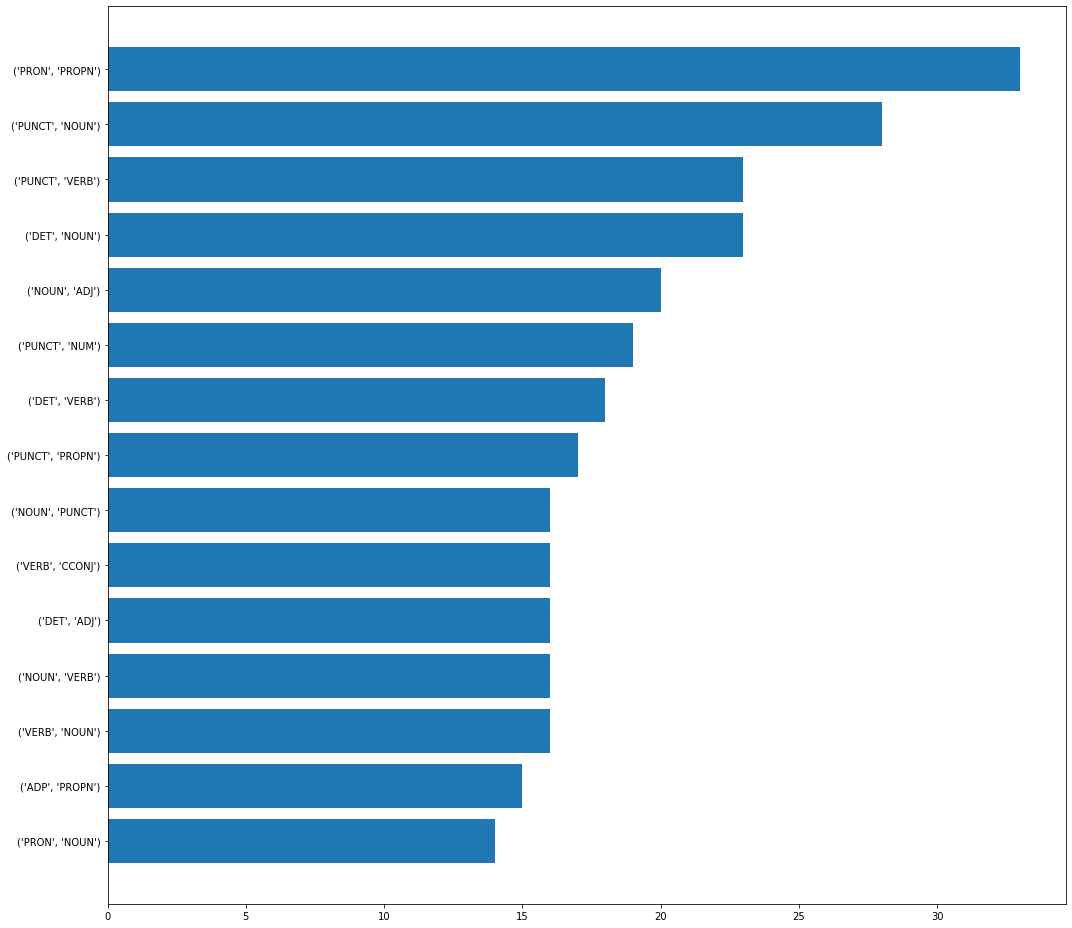

In [27]:
plt.rcParams["figure.figsize"] = (15,13)
plt.barh(range(len(wrong_tuple)), list(wrong_tuple.values()), align='center')
plt.yticks(range(len(wrong_tuple)), list(wrong_tuple.keys()))
# plt.xticks(rotation=90)
# plt.show()
plt.tight_layout()
plt.savefig('../img/wrong_tuple_hmm.png', bbox_inches='tight', pad_inches=0.0)